In [1]:
# import
import os, sys, glob
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import categorical_kde_plot, reg_plot, brain_scatter_plot, null_plot
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string
from snaplab_tools.prediction.regression import Regression
from snaplab_tools.utils import get_null_p

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
which_data = 'HCPYA'
outdir = '/home/lindenmp/research_projects/nct_xr/results/{0}'.format(which_data)

atlas = 'Schaefer4007'
if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100

subjects_file = os.path.join(indir, 'HCPYA_{0}_subjids.txt'.format(atlas))
subject_ids = np.loadtxt(subjects_file, dtype=int)
n_subs = len(subject_ids)
print(n_subs)

A_file = os.path.join(indir, 'HCPYA_{0}_A.npy'.format(atlas))
adjacency = np.load(A_file)
print(adjacency.shape)

myelin_file = os.path.join(indir, 'HCPYA_{0}_myelin.npy'.format(atlas))
myelin = np.load(myelin_file)
print(myelin.shape)

n_nodes = adjacency.shape[0]

960
(400, 400, 960)
(400, 960)


In [3]:
hcp_cog_measures = [
    'PMAT24_A_CR', # fluid intelligence
    'VSPLOT_TC', # spatial orientation
    'ListSort_Unadj', # working memory
    'DDisc_AUC_40K', # delay discounting
    'Flanker_Unadj', # executive function
]

# restricted data for age
df_rest = pd.read_csv(glob.glob(os.path.join(indir, 'RESTRICTED_lindenmp*.csv'))[0])
df_rest.set_index('Subject', inplace=True)
df_rest = df_rest[['Age_in_Yrs', 'Family_ID']]

# unrestricted data for sex and behavioral measures
df_unrest = pd.read_csv(glob.glob(os.path.join(indir, 'unrestricted_lindenmp*.csv'))[0])
df_unrest.set_index('Subject', inplace=True)
df_sex = df_unrest['Gender']
df_unrest = df_unrest[hcp_cog_measures]
df = pd.merge(df_rest, df_sex, left_index=True, right_index=True)
df = pd.merge(df, df_unrest, left_index=True, right_index=True)

df = df.loc[subject_ids, :]
# df

In [4]:
np.round(df['Age_in_Yrs'].mean(), 2)

28.7

In [5]:
np.round(df['Age_in_Yrs'].std(), 2)

3.72

In [6]:
df['Age_in_Yrs'].min()

22

In [7]:
df['Age_in_Yrs'].max()

37

In [8]:
np.round(np.sum(df['Gender'] == 'F') / n_subs * 100, 0)

53.0

In [9]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
parc_centroids = pd.read_csv(os.path.join(indir, 'Schaefer2018_{0}Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'.format(n_parcels)), index_col=1)
parc_centroids.drop(columns=['ROI Label'], inplace=True)
print(parc_centroids.head())

distance_matrix = distance.pdist(
    parc_centroids, "euclidean"
)  # get euclidean distances between nodes
distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix

                     R   A   S
ROI Name                      
7Networks_LH_Vis_1 -33 -42 -21
7Networks_LH_Vis_2 -30 -33 -18
7Networks_LH_Vis_3 -36 -62 -17
7Networks_LH_Vis_4 -24 -55  -8
7Networks_LH_Vis_5 -23 -73 -10


In [10]:
file_prefix = '{0}-{1}-Am_optimal-'.format(which_data, atlas)

n_states = 7

c = 1
time_horizon = 1
rho = 1
reference_state = 'xf'
init_weights = 'one'
n_steps = 1000
lr = 0.01
eig_weight = 1.0
reg_weight = 0.0001
reg_type = 'l2'

In [11]:
mask = np.zeros((n_states, n_states)).astype(bool)
mask[np.eye(n_states) == 1] = True
n_transitions = n_states * n_states

In [12]:
control_energy = np.zeros((n_states, n_states, n_subs))
control_energy_variable_decay = np.zeros((n_states, n_states, n_subs))
control_energy_static_decay = np.zeros((n_states, n_states, n_subs))

adjacency_weights = np.zeros((n_states, n_states, n_nodes, n_subs))

for i in tqdm(np.arange(n_subs)):
    file_str = 'HCPYA-{0}-adj-{1}_optimal-optimized-energy_k-{2}_c-{3}_T-{4}_rho-{5}_refstate-{6}_initweights-{7}_nsteps-{8}_lr-{9}_eigweight-{10}_regweight-{11}_regtype-{12}'.format(atlas,  i, 
                                                                                                                                                                                       n_states, 
                                                                                                                                                                                       c, time_horizon, rho,
                                                                                                                                                                                       reference_state, init_weights,
                                                                                                                                                                                       n_steps, lr, eig_weight, reg_weight, reg_type)
    log_args = np.load(os.path.join(outdir, 'subjects', file_str + '.npy'), allow_pickle=True).item()
    
    control_energy[:, :, i] = log_args['control_energy']
    control_energy_variable_decay[:, :, i] = log_args['control_energy_variable_decay']
    control_energy_static_decay[:, :, i] = log_args['control_energy_static_decay']
    adjacency_weights[:, :, :, i] = log_args['optimized_weights']

print(control_energy.shape, control_energy_variable_decay.shape, control_energy_static_decay.shape, adjacency_weights.shape)

100%|██████████| 960/960 [00:00<00:00, 1988.94it/s]

(7, 7, 960) (7, 7, 960) (7, 7, 960) (7, 7, 400, 960)


# Optimized decay rates

  0%|          | 0/3 [00:00<?, ?it/s]

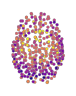

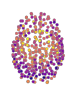

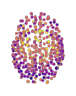

100%|██████████| 3/3 [00:00<00:00, 40.00it/s]


In [13]:
for i in tqdm(np.arange(3)):
    f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=adjacency_weights[:, :, :, i].mean(axis=0).mean(axis=0), fig_height=1, add_colorbar=False)
    # f.savefig(os.path.join(outdir, 'opt_weights-subj-{0}_brain_map.svg'.format(i)), dpi=600, bbox_inches="tight", pad_inches=0.01)

# Control energy

In [14]:
my_colors = get_my_colors(cat_trio=True, as_list=True)

# df['INT_uniform'] = control_energy[~mask].mean(axis=0)
df['INT_uniform'] = control_energy_static_decay[~mask].mean(axis=0)
df['INT_optimized'] = control_energy_variable_decay[~mask].mean(axis=0)
df['adjacency_weights'] = adjacency_weights.mean(axis=0).mean(axis=0).mean(axis=0)

# df['INT_uniform'] = control_energy[1, 2]
# df['INT_uniform'] = control_energy_static_decay[1, 2]
# df['INT_optimized'] = control_energy_variable_decay[1, 2]
print(np.sum(df['INT_optimized'].mean() - df['INT_uniform'].mean()))
print(sp.stats.ttest_rel(df['INT_optimized'], df['INT_uniform']))
print(np.sum(df['INT_optimized'] < df['INT_uniform']) / n_transitions)
# df.head()

-745.4001520238198
TtestResult(statistic=-12419.214467539972, pvalue=0.0, df=959)
19.591836734693878


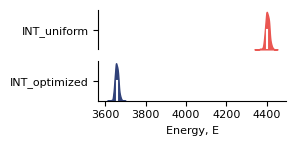

,variable,"Energy, E"
0,INT_uniform,4412.750546
1,INT_uniform,4404.336566
2,INT_uniform,4405.899648
3,INT_uniform,4410.339520
4,INT_uniform,4394.232049


In [15]:
df_plot = df[['INT_uniform', 'INT_optimized']].melt()
df_plot.rename(columns={'value': 'Energy, E'}, inplace=True)
f = categorical_kde_plot(df=df_plot, variable='Energy, E', category='variable', horizontal=True, color_palette=my_colors, rug=False, fig_width=3, fig_height=1.5)
# f.savefig(os.path.join(outdir, 'energy_violin.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
df_plot.head()

['PMAT24_A_CR', 'VSPLOT_TC', 'ListSort_Unadj', 'DDisc_AUC_40K', 'Flanker_Unadj', 'cog_mean'] 6


/tmp/ipykernel_10953/1904079954.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  f.tight_layout()


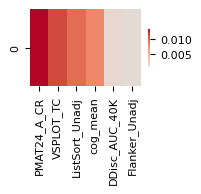

In [16]:
y_vars = hcp_cog_measures.copy()
df['cog_mean'] = df[y_vars].mean(axis=1)
y_vars.append('cog_mean')

n_vars = len(y_vars)
print(y_vars, n_vars)

corr_matrix = np.zeros((n_vars, 2))
for i in np.arange(n_vars):
    try:
        nan_mask = np.isnan(df[y_vars[i]])
        # corr_matrix[i, 0] = sp.stats.spearmanr(df[y_vars[i]], df['INT_uniform'])[0]
        # corr_matrix[i, 1] = sp.stats.spearmanr(df[y_vars[i]], df['INT_optimized'])[0]
        corr_matrix[i, 0] = sp.stats.pearsonr(df[y_vars[i]][~nan_mask], df['INT_uniform'][~nan_mask])[0]
        corr_matrix[i, 1] = sp.stats.pearsonr(df[y_vars[i]][~nan_mask], df['INT_optimized'][~nan_mask])[0]
    except:
        corr_matrix[i, 0] = np.nan
        corr_matrix[i, 1] = np.nan

corr_diff = np.abs(corr_matrix[:, 1]) - np.abs(corr_matrix[:, 0])
sort_idx = np.argsort(corr_diff)[::-1]
corr_diff = corr_diff[sort_idx]
corr_diff = corr_diff[:, np.newaxis]

f, ax = plt.subplots(1, 1, figsize=(n_vars*.3, 1))
sns.heatmap(corr_diff.T, ax=ax, square=False, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.5})
# ax.set_xlabel('Transition')
# ax.set_ylabel('Gene map')
# ax.set_xticklabels(['INT_uniform', 'INT_optimized'], rotation=90)
ax.set_xticks(np.arange(n_vars)+0.5)
my_list = [y_vars[i] for i in sort_idx]
ax.set_xticklabels(my_list, rotation=90)
f.tight_layout()
plt.show()

In [17]:
y_vars[:] = [y_vars[i] for i in sort_idx]
df[y_vars].head()

,PMAT24_A_CR,VSPLOT_TC,ListSort_Unadj,cog_mean,DDisc_AUC_40K,Flanker_Unadj
Subject,,,,,,
100206,20.0,12.0,112.89,55.072000,0.050000,130.42
100307,17.0,9.0,108.06,49.386292,0.311459,112.56
100408,7.0,17.0,108.06,50.732271,0.421354,121.18
100610,23.0,18.0,117.39,57.157750,0.868750,126.53
101006,11.0,20.0,93.90,45.506615,0.783073,101.85


In [18]:
# (self, X, y, c=None, alg='rr', score='rmse', n_splits=10, runpca=False, n_rand_splits=100)'
alg = 'rr'
score = 'r2'
secondary_score = 'corr'
n_splits = 5
runpca = False
n_rand_splits = 100
n_perm = 5000

# covs = ['age', 'sex', 'A_d']
covs = ['Age_in_Yrs', 'Gender']
# covs = ['Gender', ]
c = df[covs]
c.loc[:, 'Gender'] = c['Gender'] == 'Male'
c.loc[:, 'Gender'] = c['Gender'].values.astype(int)
c = c.values
print(c)

[[27 0]
 [27 0]
 [33 0]
 ...
 [29 0]
 [30 0]
 [28 0]]


In [19]:
strength = np.sum(adjacency, axis=0).T
include_strength = False
if include_strength is True:
    X_features = [control_energy_static_decay[~mask].T, control_energy_variable_decay[~mask].T, strength]
else:
    X_features = [control_energy_static_decay[~mask].T, control_energy_variable_decay[~mask].T]

In [20]:
n_X_features = len(X_features)
# y_vars = ['cog_mean',]
# n_y_vars = len(hcp_cog_measures)
n_y_vars = len(y_vars)

accuracy = np.zeros((n_X_features, n_y_vars, n_rand_splits))
accuracy_perm = np.zeros((n_X_features, n_y_vars, n_perm))

secondary_accuracy = np.zeros((n_X_features, n_y_vars, n_rand_splits))
secondary_accuracy_perm = np.zeros((n_X_features, n_y_vars, n_perm))

for i in np.arange(n_X_features):
    X = X_features[i]
    print(X.shape)
    for j in np.arange(n_y_vars):
        y_var = y_vars[j]
        print(y_var)
        y = df[y_var].values
        nan_mask = np.isnan(y)
        regression = Regression(X=X[~nan_mask], y=y[~nan_mask], c=c, alg=alg, score=score, secondary_score=secondary_score, n_splits=n_splits, runpca=runpca, n_rand_splits=n_rand_splits, verbose=True)
        regression.run()
        accuracy[i, j] = regression.accuracy_mean.copy()
        secondary_accuracy[i, j] = regression.secondary_accuracy_mean.copy()
        if n_perm > 0:
            regression.run_perm(n_perm=n_perm)
            accuracy_perm[i, j] = regression.accuracy_perm.copy()
            secondary_accuracy_perm[i, j] = regression.secondary_accuracy_perm.copy()

(960, 42)
PMAT24_A_CR
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 79.23it/s]


Average prediction accuracy: 0.03+/-0.03 
	Average prediction accuracy (secondary): 0.20+/-0.05 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:00<00:00, 82.11it/s]


VSPLOT_TC
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 82.52it/s]


Average prediction accuracy: 0.04+/-0.03 
	Average prediction accuracy (secondary): 0.22+/-0.06 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:01<00:00, 81.24it/s]


ListSort_Unadj
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 81.79it/s]


Average prediction accuracy: 0.01+/-0.03 
	Average prediction accuracy (secondary): 0.14+/-0.06 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:00<00:00, 82.27it/s]


cog_mean
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 79.36it/s]


Average prediction accuracy: 0.00+/-0.03 
	Average prediction accuracy (secondary): 0.12+/-0.08 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:01<00:00, 81.62it/s]


DDisc_AUC_40K
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 80.13it/s]


Average prediction accuracy: -0.01+/-0.02 
	Average prediction accuracy (secondary): 0.10+/-0.06 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:01<00:00, 81.50it/s]


Flanker_Unadj
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 81.04it/s]


Average prediction accuracy: -0.01+/-0.02 
	Average prediction accuracy (secondary): 0.08+/-0.05 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:01<00:00, 81.44it/s]


(960, 42)
PMAT24_A_CR
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 79.72it/s]


Average prediction accuracy: 0.04+/-0.03 
	Average prediction accuracy (secondary): 0.22+/-0.06 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:01<00:00, 81.23it/s]


VSPLOT_TC
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 79.61it/s]


Average prediction accuracy: 0.05+/-0.03 
	Average prediction accuracy (secondary): 0.24+/-0.06 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:02<00:00, 80.57it/s]


ListSort_Unadj
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 80.90it/s]


Average prediction accuracy: 0.02+/-0.03 
	Average prediction accuracy (secondary): 0.17+/-0.06 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:01<00:00, 81.38it/s]


cog_mean
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 80.69it/s]


Average prediction accuracy: 0.01+/-0.03 
	Average prediction accuracy (secondary): 0.16+/-0.08 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:01<00:00, 81.69it/s]


DDisc_AUC_40K
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 80.07it/s]


Average prediction accuracy: -0.00+/-0.02 
	Average prediction accuracy (secondary): 0.12+/-0.06 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:01<00:00, 80.83it/s]


Flanker_Unadj
Pipeline: regression (out-of-sample regression)
	settings:
		alg: rr
		score: r2
		secondary score: corr
		n_splits: 5
		runpca: False
		n_rand_splits: 100


100%|██████████| 100/100 [00:01<00:00, 76.16it/s]


Average prediction accuracy: -0.01+/-0.03 
	Average prediction accuracy (secondary): 0.10+/-0.05 
Pipeline: prediction, permutation test


100%|██████████| 5000/5000 [01:02<00:00, 80.49it/s]


0.020000000000000018


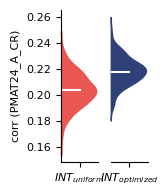

0.0


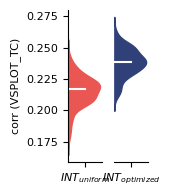

0.0


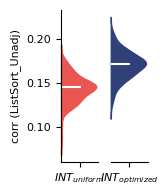

0.0


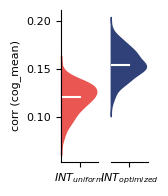

0.06000000000000005


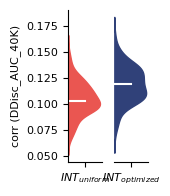

0.020000000000000018


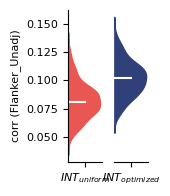

In [21]:
for j in np.arange(n_y_vars):
    # primary score
    df_plot = pd.DataFrame(index=np.arange(n_rand_splits))
    df_plot['$INT_{uniform}$'] = accuracy[0, j]
    df_plot['$INT_{optimized}$'] = accuracy[1, j]
    if include_strength is True:
        df_plot['Strength'] = accuracy[2, j]
    
    # print(np.sum(df_plot['$INT_{optimized}$'] > df_plot['$INT_{uniform}$']) / n_rand_splits)

    df_plot = df_plot.melt()
    value = '{0} ({1})'.format(score, y_vars[j])
    df_plot.rename(columns={'value': value}, inplace=True)
    # f = categorical_kde_plot(df=df_plot, variable=value, category='variable', horizontal=False, color_palette=my_colors, rug=False, fig_width=2, fig_height=1.625)
    # f.savefig(os.path.join(outdir, 'hcp_prediction_violin_r2.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
    # successful_prediction = np.median(df_plot.iloc[:, 1]) > 0

    # if successful_prediction == True:
    # secondary score
    df_plot = pd.DataFrame(index=np.arange(n_rand_splits))
    df_plot['$INT_{uniform}$'] = secondary_accuracy[0, j]
    df_plot['$INT_{optimized}$'] = secondary_accuracy[1, j]
    # if include_strength is True:
        # df_plot['Strength'] = secondary_accuracy[2, j]
    
    print(1 - np.sum(df_plot['$INT_{optimized}$'] > df_plot['$INT_{uniform}$']) / n_rand_splits)

    df_plot = df_plot.melt()
    value = '{0} ({1})'.format(secondary_score, y_vars[j])
    df_plot.rename(columns={'value': value}, inplace=True)
    # f = categorical_kde_plot(df=df_plot, variable=value, category='variable', horizontal=True, color_palette=my_colors, rug=False, fig_width=2.5, fig_height=1.25)
    f = categorical_kde_plot(df=df_plot, variable=value, category='variable', horizontal=False, color_palette=my_colors, rug=False, fig_width=2, fig_height=1.625)
    f.savefig(os.path.join(outdir, 'hcp_prediction_violin_{0}.svg'.format(y_vars[j])), dpi=600, bbox_inches="tight", pad_inches=0.01)

PMAT24_A_CR
0.2 -log10($\mathit{p}$)>25


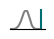

0.22 -log10($\mathit{p}$)>25


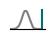

VSPLOT_TC
0.22 -log10($\mathit{p}$)>25


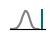

0.24 -log10($\mathit{p}$)>25


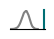

ListSort_Unadj
0.14 -log10($\mathit{p}$)>25


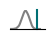

0.17 -log10($\mathit{p}$)>25


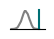

cog_mean
0.12 $\mathit{p}$=1e-03


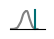

0.16 -log10($\mathit{p}$)>25


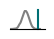

DDisc_AUC_40K
0.1 $\mathit{p}$=8e-03


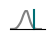

0.12 $\mathit{p}$=3e-03


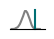

Flanker_Unadj
0.08 $\mathit{p}$=3e-02


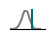

0.1 $\mathit{p}$=8e-03


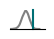

In [22]:
for j in np.arange(n_y_vars):
    print(y_vars[j])
    # # primary score
    # f, ax = plt.subplots(2, 1, figsize=(1.25, 1.25))
    # for i in np.arange(n_X_features):
    #     observed = accuracy[i, j].mean()
    #     null = accuracy_perm[i, j]
    #     p_val = get_null_p(observed, null)
    #     null_plot(observed, null, '', ax=ax[i], p_val=p_val, add_text=False)
    # f.tight_layout()

    # secondary score
    for i in np.arange(n_X_features):
        observed = secondary_accuracy[i, j].mean()
        null = secondary_accuracy_perm[i, j]
        p_val = get_null_p(observed, null)
        print(np.round(observed, 2), get_p_val_string(p_val))
        f, ax = plt.subplots(1, 1, figsize=(.45, .25))
        null_plot(observed, null, '', ax=ax, p_val=p_val, add_text=False, use_kde=True)
        ax.set_xlim([-0.2, 0.25])
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        ax.set_ylabel('')
        sns.despine(left=True, ax=ax)
        # if i == n_X_features-1:
            # ax.set_xlabel('empirical null')
        plt.show()
        f.savefig(os.path.join(outdir, 'hcp_prediction_null_{0}_{1}.svg'.format(i, y_vars[j])), dpi=600, bbox_inches="tight", pad_inches=0.01)